In [1]:
import numpy as np
import pandas as pd
import os
import calendar
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
pd.options.display.max_columns =100
from tqdm import tqdm
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras.layers import SimpleRNN, Dense
import warnings
from contextlib import nullcontext
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def readAllCSV():

  month_mapping = {month: index for index, month in enumerate(calendar.month_name) if month}

  file_list = os.listdir('data')

  file_list = sorted(file_list, key=lambda x: month_mapping.get(x.split('.')[0]))
  dfs = []
  for file_name in file_list:
      
      file_path = os.path.join('data', file_name)
      df = pd.read_csv(file_path, delimiter = ';',  encoding = 'latin-1')
      dfs.append(df)
  return dfs

def extractUsefulInfo(table, columns):

  df = table[columns]
  df = df.drop(df.index[0])
  df[columns] = df[columns].astype(float)
  print("Printing NaN's")
  print(df.isna().sum())
  df.dropna(inplace=True)
  return df


def plots(df,column,q_low,q_hi):
  # Set the style of the plot
  sns.set_style("whitegrid")

  # Set the thresholds
  low_threshold = df[column].quantile(q_low)
  high_threshold = df[column].quantile(q_hi)

  # Filter the data
  filtered_data = df[
      (df[column] >= low_threshold) &
      (df[column] <= high_threshold)
  ]

  # Downsampling the data
  max_data_points = 2000  # Maximum number of data points to plot
  if len(filtered_data) > max_data_points:
      indices = np.linspace(0, len(filtered_data) - 1, max_data_points, dtype=int)
      downsampled_data = filtered_data.iloc[indices]
  else:
      downsampled_data = filtered_data

  # Create the plot using Seaborn
  plt.figure(figsize=(10, 6))
  sns.lineplot(x='date', y=column, data=downsampled_data)

  # Set the x-axis tick labels
  num_ticks = 10
  step = len(downsampled_data) // num_ticks
  x_ticks = downsampled_data['date'][::step]
  plt.xticks(x_ticks, rotation=90)

  # Set the plot labels and title
  plt.xlabel('Date')
  plt.ylabel(column)
  plt.title('Visualization of ' + column + ' (Filtered)')

  # Display the plot
  plt.show()


In [3]:
df_list = readAllCSV()

C:\Users\msi\AppData\Local\Temp\ipykernel_8032\2314126731.py:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  df_list = readAllCSV()
C:\Users\msi\AppData\Local\Temp\ipykernel_8032\2314126731.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94) have mixed types.Specify dtype option on import or set low_memory=False.
  df_list = readAllCSV()
C:\Users\msi\AppData\Local\Temp\ipykernel_8032\2314126731.py:1: DtypeWarning: Columns (4,5,6

In [4]:
june = df_list[1]
june['date1']  = pd.to_datetime(june['date'],format='%d/%m/%Y %H:%M' ,errors='coerce')#, infer_datetime_format=True)# , errors='ignore')
june['date2'] =pd.to_datetime(june['date'], format= '%Y-%m-%d %H:%M:%S.%f', errors='coerce')
june['combined_date'] = june['date1'].combine_first(june['date2'])
june.drop(['date1'], axis=1)
june.drop(['date2'], axis=1)
june.drop(['date'], axis=1)
june['date'] = june['combined_date']
june.drop(['combined_date'], axis=1)
june['date'] 

0                       NaT
1       2019-06-01 00:00:00
2       2019-06-01 00:00:00
3       2019-06-01 00:01:00
4       2019-06-01 00:01:00
                ...        
77144   2019-06-30 23:58:00
77145   2019-06-30 23:58:00
77146   2019-06-30 23:58:00
77147   2019-06-30 23:59:00
77148   2019-06-30 23:59:00
Name: date, Length: 77149, dtype: datetime64[ns]

In [5]:
columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv','cement_type_cpiv_bool_pv', 'mill_operation']

june_first = extractUsefulInfo(june,columns)
june_first['date'] = june['date']

Printing NaN's
separator_speed_rpm_pv      10
mill_dp_mbar_pv             14
separator_pwr_kw_pv         14
cement_type_cpii_bool_pv    14
cement_type_cpiv_bool_pv    11
mill_operation              14
dtype: int64


In [6]:
june.shape

(77149, 99)

In [7]:
# Remove rows where both column1 and column2 are 1
june = june[(june['cement_type_cpiv_bool_pv'] != 1) | (june['cement_type_cpii_bool_pv'] != 1)]


In [8]:
june.shape

(77149, 99)

In [9]:

cement_1 = june_first[(june_first['cement_type_cpiv_bool_pv'] == 1) & (june_first['cement_type_cpii_bool_pv'] == 0) & (june_first['mill_operation'] == 1)]


cement_2 = june_first[(june_first['cement_type_cpiv_bool_pv'] == 0) & (june_first['cement_type_cpii_bool_pv'] == 1) & (june_first['mill_operation'] == 1)]

In [10]:
print(cement_1.shape)
print(cement_2.shape)

(28080, 7)
(17310, 7)


In [11]:

na1=june_first['date'].isna().sum()
na1

0

In [12]:
na1=cement_1['date'].isna().sum()

na1

0

In [13]:

cement_1['date']

7775    2019-06-03 16:47:00
7776    2019-06-03 16:47:00
7777    2019-06-03 16:48:00
7778    2019-06-03 16:48:00
7782    2019-06-03 16:50:00
                ...        
77144   2019-06-30 23:58:00
77145   2019-06-30 23:58:00
77146   2019-06-30 23:58:00
77147   2019-06-30 23:59:00
77148   2019-06-30 23:59:00
Name: date, Length: 28080, dtype: datetime64[ns]

In [14]:
i = pd.to_datetime('2019-06-01 00:00:00')
end_date = pd.to_datetime('2019-07-01 00:00:00')

progress_bar = tqdm(total=(end_date - i).total_seconds())
filtered_dfs = []
total_rows = 0

while i < end_date:

    filtered_rows = cement_1[cement_1['date'] == str(i)]
    if len(filtered_rows) < 1 :
        total_rows+=1
        progress_bar.update(30)
        i += pd.Timedelta(seconds=30)
        continue
    averaged_df = filtered_rows.groupby('date').mean().reset_index()

    filtered_dfs.append(averaged_df)
    
    total_rows+=1
    progress_bar.update(30)
    i += pd.Timedelta(seconds=30)

progress_bar.close()
filtered_df = pd.concat(filtered_dfs)
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
print(total_rows)

100%|██████████| 2592000/2592000.0 [01:22<00:00, 31576.88it/s]


86400


In [15]:
filtered_df = pd.concat(filtered_dfs)
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

In [16]:
filtered_df.dtypes



date                        datetime64[ns]
separator_speed_rpm_pv             float64
mill_dp_mbar_pv                    float64
separator_pwr_kw_pv                float64
cement_type_cpii_bool_pv           float64
cement_type_cpiv_bool_pv           float64
mill_operation                     float64
dtype: object

In [17]:
i = pd.to_datetime('2019-06-01 00:00:00')
progress_bar = tqdm(total=(end_date - i).total_seconds())

end_date = pd.to_datetime('2019-07-01 00:00:00')
numeric_cols = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv','cement_type_cpiv_bool_pv', 'mill_operation']
int_cols = ['cement_type_cpii_bool_pv','cement_type_cpiv_bool_pv', 'mill_operation']
reset = 0 
while i < end_date:   
    filtered_rows = filtered_df[filtered_df['date'] == str(i)]

    progress_bar.update(30)
    if len(filtered_rows) < 1 and reset < 1:
        reset +=1 
        preceding_row = filtered_df[filtered_df['date'] < str(i)].tail(1)
        following_row = filtered_df[filtered_df['date'] > str(i)].head(1)
        if not (preceding_row.empty or following_row.empty):
            
            mean_values = (preceding_row.iloc[0][numeric_cols] + following_row.iloc[0][numeric_cols])
            mean_values[numeric_cols] = mean_values[numeric_cols] / 2

            new_row = pd.DataFrame([mean_values], columns=filtered_df.columns)
            new_row['date'] = i
            new_row[int_cols] = new_row[int_cols].applymap(lambda x: 0 if x < 1 else x)

            filtered_df = filtered_df.append(new_row, ignore_index=True)

    else:
        reset = 0
    i += pd.Timedelta(seconds=30)

filtered_df[int_cols] = filtered_df[int_cols].applymap(lambda x: 0 if x < 1 else x)    

progress_bar.close()


  0%|          | 0/2592000.0 [00:00<?, ?it/s]

100%|██████████| 2592000/2592000.0 [07:35<00:00, 5686.61it/s] 


In [18]:
filtered_df= filtered_df.sort_values('date')
filtered_df

,date,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,cement_type_cpii_bool_pv,cement_type_cpiv_bool_pv,mill_operation
0,2019-06-03 16:47:00,700.980000,33.815000,55.255000,0,1.0,1.0
17426,2019-06-03 16:47:30,656.815000,35.160000,65.165000,0,1.0,1.0
1,2019-06-03 16:48:00,612.650000,36.505000,75.075000,0,1.0,1.0
17427,2019-06-03 16:48:30,592.682500,33.650000,61.072500,0,1.0,1.0
17428,2019-06-03 16:49:30,560.616250,32.895000,59.026250,0,1.0,1.0
...,...,...,...,...,...,...,...
17423,2019-06-30 23:57:00,718.697500,33.085000,56.100000,0,1.0,1.0
52876,2019-06-30 23:57:30,712.781524,33.485623,56.395750,0,1.0,1.0
17424,2019-06-30 23:58:00,719.070000,33.565000,56.755000,0,1.0,1.0
52877,2019-06-30 23:58:30,723.293262,33.657811,56.455375,0,1.0,1.0


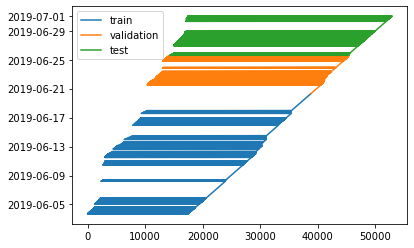

In [19]:
train_set = filtered_df[:int(6*len(filtered_df)/10)]['date']
validation_set = filtered_df[int(6*len(filtered_df)/10):int(8*len(filtered_df)/10)]['date']
test_set = filtered_df[int(8*len(filtered_df)/10):]['date']

train_set.plot(label='train')
validation_set.plot(label='validation')
test_set.plot(label='test')

plt.legend()

In [20]:
def build_dset(dset,col, lookback, horizon):
    dset = dset[col]
    data = pd.concat([dset.shift(-i) for i in range(lookback+horizon)], axis=1).dropna()

    return data.iloc[:, :lookback], data.iloc[:, lookback:]

In [21]:
train_set = filtered_df[:int(6*len(filtered_df)/10)]
validation_set = filtered_df[int(6*len(filtered_df)/10):int(8*len(filtered_df)/10)]
test_set = filtered_df[int(8*len(filtered_df)/10):]

In [34]:
def create_Windows(set):
    lookback = 10
    horizon = 5
    columns = ['date', 'separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv']
    input_columns = ['separator_speed_rpm_pv','mill_dp_mbar_pv']
    X_list = []
    tmp = []
    for col in columns[:-1]:
        x, _ = build_dset(set, col, lookback, horizon)
        X_list.append(x)




    # remove windows that will have missing dates
    threshold = lookback * pd.Timedelta(seconds=30)
    index_toremove = []
    for index, row in X_list[0].iterrows():
        t1 = row.iloc[0]
        t2 = row.iloc[-1]
        difference = t2 - t1

        if (difference > threshold ):
            index_toremove.append(index)
            
    mask = ~X_list[0].index.isin(index_toremove)

    for i in range(len(X_list)):
        X_list[i] = X_list[i].loc[mask]




    for en in range(0,lookback):
        tmp.append(pd.concat([df.iloc[:, en] for df in X_list], axis=1))

    x_train = pd.concat(tmp, axis=1)  
    x_train.columns = [f'{input_columns[i%len(input_columns)]}_column_{i}' for i in range(x_train.shape[1])]

    _, y_train = build_dset(set, columns[-1], lookback, horizon)
    
    # also remove from y_train the missing dates
    y_train = y_train[mask]
    return x_train,y_train

In [35]:
x_train,y_train = create_Windows(train_set)
x_validation,y_validation = create_Windows(validation_set)
x_test,y_test = create_Windows(test_set)

In [36]:
x_train

,separator_speed_rpm_pv_column_0,mill_dp_mbar_pv_column_1,separator_speed_rpm_pv_column_2,mill_dp_mbar_pv_column_3,separator_speed_rpm_pv_column_4,mill_dp_mbar_pv_column_5,separator_speed_rpm_pv_column_6,mill_dp_mbar_pv_column_7,separator_speed_rpm_pv_column_8,mill_dp_mbar_pv_column_9,separator_speed_rpm_pv_column_10,mill_dp_mbar_pv_column_11,separator_speed_rpm_pv_column_12,mill_dp_mbar_pv_column_13,separator_speed_rpm_pv_column_14,mill_dp_mbar_pv_column_15,separator_speed_rpm_pv_column_16,mill_dp_mbar_pv_column_17,separator_speed_rpm_pv_column_18,mill_dp_mbar_pv_column_19,separator_speed_rpm_pv_column_20,mill_dp_mbar_pv_column_21,separator_speed_rpm_pv_column_22,mill_dp_mbar_pv_column_23,separator_speed_rpm_pv_column_24,mill_dp_mbar_pv_column_25,separator_speed_rpm_pv_column_26,mill_dp_mbar_pv_column_27,separator_speed_rpm_pv_column_28,mill_dp_mbar_pv_column_29
0,2019-06-03 16:47:00,700.98000,33.815,2019-06-03 16:47:30,656.81500,35.160,2019-06-03 16:48:00,612.650000,36.5050,2019-06-03 16:48:30,592.682500,33.6500,2019-06-03 16:49:30,560.616250,32.89500,2019-06-03 16:50:00,528.550000,32.14000,2019-06-03 16:50:30,587.373125,33.857500,2019-06-03 16:51:00,614.130000,34.820000,2019-06-03 16:51:30,644.124063,33.718750,2019-06-03 16:52:00,700.875000,33.580000
17426,2019-06-03 16:47:30,656.81500,35.160,2019-06-03 16:48:00,612.65000,36.505,2019-06-03 16:48:30,592.682500,33.6500,2019-06-03 16:49:30,560.616250,32.8950,2019-06-03 16:50:00,528.550000,32.14000,2019-06-03 16:50:30,587.373125,33.85750,2019-06-03 16:51:00,614.130000,34.820000,2019-06-03 16:51:30,644.124063,33.718750,2019-06-03 16:52:00,700.875000,33.580000,2019-06-03 16:52:30,672.604531,33.359375
1,2019-06-03 16:48:00,612.65000,36.505,2019-06-03 16:48:30,592.68250,33.650,2019-06-03 16:49:30,560.616250,32.8950,2019-06-03 16:50:00,528.550000,32.1400,2019-06-03 16:50:30,587.373125,33.85750,2019-06-03 16:51:00,614.130000,34.82000,2019-06-03 16:51:30,644.124063,33.718750,2019-06-03 16:52:00,700.875000,33.580000,2019-06-03 16:52:30,672.604531,33.359375,2019-06-03 16:53:00,701.085000,33.000000
17427,2019-06-03 16:48:30,592.68250,33.650,2019-06-03 16:49:30,560.61625,32.895,2019-06-03 16:50:00,528.550000,32.1400,2019-06-03 16:50:30,587.373125,33.8575,2019-06-03 16:51:00,614.130000,34.82000,2019-06-03 16:51:30,644.124063,33.71875,2019-06-03 16:52:00,700.875000,33.580000,2019-06-03 16:52:30,672.604531,33.359375,2019-06-03 16:53:00,701.085000,33.000000,2019-06-03 16:53:30,702.992266,32.839687
17428,2019-06-03 16:49:30,560.61625,32.895,2019-06-03 16:50:00,528.55000,32.140,2019-06-03 16:50:30,587.373125,33.8575,2019-06-03 16:51:00,614.130000,34.8200,2019-06-03 16:51:30,644.124063,33.71875,2019-06-03 16:52:00,700.875000,33.58000,2019-06-03 16:52:30,672.604531,33.359375,2019-06-03 16:53:00,701.085000,33.000000,2019-06-03 16:53:30,702.992266,32.839687,2019-06-03 16:54:00,733.380000,32.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10338,2019-06-17 22:57:00,741.59000,33.290,2019-06-17 22:57:30,742.17000,32.730,2019-06-17 22:58:00,741.330000,32.5500,2019-06-17 22:58:30,742.230000,32.6100,2019-06-17 22:59:00,742.700000,32.94000,2019-06-17 22:59:30,742.120000,32.85000,2019-06-17 23:00:00,741.060000,32.940000,2019-06-17 23:00:30,741.540000,33.190000,2019-06-17 23:01:00,741.650000,33.230000,2019-06-17 23:01:30,742.170000,33.190000
10339,2019-06-17 22:57:30,742.17000,32.730,2019-06-17 22:58:00,741.33000,32.550,2019-06-17 22:58:30,742.230000,32.6100,2019-06-17 22:59:00,742.700000,32.9400,2019-06-17 22:59:30,742.120000,32.85000,2019-06-17 23:00:00,741.060000,32.94000,2019-06-17 23:00:30,741.540000,33.190000,2019-06-17 23:01:00,741.650000,33.230000,2019-06-17 23:01:30,742.170000,33.190000,2019-06-17 23:02:00,745.080000,31.490000
10340,2019-06-17 22:58:00,741.33000,32.550,2019-06-17 22:58:30,742.23000,32.610,2019-06-17 22:59:00,742.700000,32.9400,2019-06-17 22:59:30,742.120000,32.8500,2019-06-17 23:00:00,741.060000,32.94

In [37]:
y_train

,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv,separator_pwr_kw_pv
0,55.925781,55.420000,55.735391,55.545000,55.737695
17426,55.420000,55.735391,55.545000,55.737695,55.740000
1,55.735391,55.545000,55.737695,55.740000,56.008848
17427,55.545000,55.737695,55.740000,56.008848,56.280000
17428,55.737695,55.740000,56.008848,56.280000,56.059424
...,...,...,...,...,...
10338,56.810000,57.010000,57.025000,57.477500,57.703750
10339,57.010000,57.025000,57.477500,57.703750,57.816875
10340,57.025000,57.477500,57.703750,57.816875,57.873438
10341,57.477500,57.703750,57.816875,57.873438,57.901719


In [26]:
# stops the RUN All here
if(n)

SyntaxError: invalid syntax (1734130098.py, line 2)

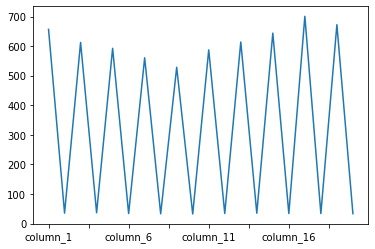

In [ ]:
x_train[1:].iloc[0].plot()


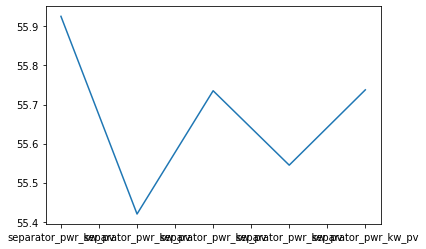

In [ ]:
y_train.iloc[0].plot()

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
preds = lr.predict(y_train)

In [ ]:
june_first = june_first[june_first['cement_type_cpii_bool_pv']==1.0]
june_first.drop(['cement_type_cpii_bool_pv'], axis=1, inplace=True)
june_first

In [ ]:
june

In [ ]:
feature_keys = [
    "separator_speed_rpm_pv",
    "mill_dp_mbar_pv",
    "separator_pwr_kw_pv"
]

titles = feature_keys

date_time_key = "date"
colors = ["red", "green", "blue", "grey"]
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(june_first)

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(june_first)

### RNN (new)

In [ ]:
features = june_first.drop(['date'], axis=1)
features.index = june_first[date_time_key]

split_fraction = 0.715
train_split = int(split_fraction * int(june_first.shape[0]))
step = 1

past = 20
future = 10 #after 10 timestamps
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [ ]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(3)]].values
y_train = features.iloc[start:end][[2]]

sequence_length = int(past / step)

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

NameError: name 'sequence_length' is not defined

In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(3)]].values
y_val = features.iloc[label_start:][[2]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [ ]:
correlation_matrix = june_first.corr()

# Create a correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
shifted_df = june_first[['separator_speed_rpm_pv', 'mill_dp_mbar_pv']].shift(10)

# Concatenate the shifted columns with the original dataframe
shifted_df = pd.concat([june_first.drop(['separator_speed_rpm_pv', 'mill_dp_mbar_pv'] , axis=1), shifted_df], axis=1)

# Drop rows with NaN values introduced by the shifting
shifted_df = shifted_df.dropna()

# Print the resulting dataframe with shifted columns
print(shifted_df)

In [ ]:
correlation_matrix = shifted_df.corr()

# Create a correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv']

june_first = extractUsefulInfo(june,columns)
june_first['date'] = june['date']

In [ ]:
july = df_list[2]
july_first = extractUsefulInfo(july,columns)
july_first

In [ ]:
q_low = 0.01
q_hi = 0.99
plots(june_first,'mill_dp_mbar_pv',q_low,q_hi)


In [ ]:
q_low = 0.05
q_hi = 0.95
plots(june_first,'separator_pwr_kw_pv',q_low,q_hi)

In [ ]:
q_low = 0.05
q_hi = 0.95
plots(june_first,'separator_speed_rpm_pv',q_low,q_hi)

In [ ]:
# Normalize data
sc = StandardScaler()
X = june_first[['mill_dp_mbar_pv', 'separator_pwr_kw_pv']]
y = june_first['separator_speed_rpm_pv']
X_test = july_first[['mill_dp_mbar_pv', 'separator_pwr_kw_pv']]
y_test =  july_first['separator_speed_rpm_pv']

X = sc.fit_transform(X)
X_test= sc.transform(X_test)


In [ ]:
# Linear Regression
model = LinearRegression()


model.fit(X, y)

predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.plot(np.linspace(0, np.max(y_test), 100), np.linspace(0, np.max(y_test), 100), color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [ ]:
# RandomForest Regressor

# My max_depth=16
param_grid = {
    'n_estimators' : [10, 50, 100, 200, 1000],
    'criterion' : ['squared_error','absolute_error', 'friedman_mse', 'poisson'],
    'max_depth' : [None, 4, 8, 12],
    'min_samples_split' : [2, 5, 8]
}
model = RandomForestRegressor()

gs = GridSearchCV(model,param_grid,scoring='neg_mean_squared_error',verbose=10,n_jobs =-1)
#gs.fit(X,y)
model.fit(X, y)

predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.plot(np.linspace(0, np.max(y_test), 100), np.linspace(0, np.max(y_test), 100), color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [ ]:
# IGNORE einai gia to deutero, apla evlepa.

columns = ['total_feed_ton/h_pv', 'fly_ash_1_ton/h_pv', 'fly_ash_2_ton/h_pv',
           'main_fan_speed_rpm_pv', 'separator_speed_rpm_pv', 'grinding_pressure_bar_pv',
           'mill_injection_water_m3/h_pv', 'bucket_elv_mtr_pwr_kw_pv', 'mill_dp_mbar_pv']

second = extractUsefulInfo(june,columns)